In [9]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [46]:
def ConvBlock(inputs, filters=64):
    conv1 = keras.layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(inputs)
    batch_norm1 = keras.layers.BatchNormalization()(conv1)
    act1 = keras.layers.ReLU()(batch_norm1)
    conv2 = keras.layers.Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = keras.layers.BatchNormalization()(conv2)
    act2 = keras.layers.ReLU()(batch_norm2)
    return act2
def encoder(inputs, filters=64):
    enc1 = ConvBlock(inputs, filters)
    MaxPool1 = keras.layers.MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1
def decoder(inputs, skip, filters=64):
    Upsample = keras.layers.Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(inputs)
    Connect_Skip = keras.layers.Concatenate()([Upsample, skip])
    out = ConvBlock(Connect_Skip, filters)
    return out
def get_U_Net(image_size):
    inputs = keras.layers.Input(image_size)
    
    skip1, encoder_1 = encoder(inputs, 32)
    skip2, encoder_2 = encoder(encoder_1, 32*2)
    skip3, encoder_3 = encoder(encoder_2, 32*4)
    skip4, encoder_4 = encoder(encoder_3, 32*4)
    
    conv_block = ConvBlock(encoder_4, 32*4)
    
    decoder_1 = decoder(conv_block, skip4, 32*4)
    decoder_2 = decoder(decoder_1, skip3, 32*4)
    decoder_3 = decoder(decoder_2, skip2, 32*2)
    decoder_4 = decoder(decoder_3, skip1, 32)
    
    outputs = keras.layers.Conv2D(3, 1, padding="same", activation="sigmoid")(decoder_4)
    
    model = keras.models.Model(inputs, outputs)
    return model

In [10]:
index_list = np.linspace(0,2999, 3000).astype(np.uint16)
np.random.shuffle(index_list)
index_list = index_list
print(index_list)

[1861 2872  147 ...   12 2557 2297]


In [11]:
locloc = "BigDataPeople" 
namename = "\Suitman_EEVEE\\SuitMan"
all_photos = np.load(locloc + namename + 'Photos.npy')
#all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
#all_vectors = np.load(locloc + namename + 'Vectors.npy')
#all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
#all_albedos = np.load(locloc + namename + 'Albedos.npy')
all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')
# Цель просто сделать рабочий генератор маски.

In [12]:
locloc = "BigDataPeople" 
namename = "\Knight_EEVEE\\Knight"
all_photos1 = np.load(locloc + namename + 'Photos.npy')
all_normals1 = np.load(locloc + namename + 'Normals.npy')
all_masks1 = np.load(locloc + namename + 'Masks.npy')

In [13]:
locloc = "BigDataPeople" 
namename = "\Woman1_EEVEE\\Woman1"
all_photos2 = np.load(locloc + namename + 'Photos.npy')
all_normals2 = np.load(locloc + namename + 'Normals.npy')
all_masks2 = np.load(locloc + namename + 'Masks.npy')

In [14]:
all_photos = np.concatenate([all_photos, all_photos1, all_photos2], axis=0) 
all_normals = np.concatenate([all_normals, all_normals1, all_normals2], axis=0) 
all_masks = np.concatenate([all_masks, all_masks1, all_masks2], axis=0) 
del all_photos1;  del all_photos2;
del all_normals1; del all_normals2;
del all_masks1;   del all_masks2;

In [15]:
all_photos = all_photos[index_list]
all_normals = all_normals[index_list]
all_masks = all_masks[index_list]

ratio = 0.96; 
all_length = round( len(all_photos) * ratio)

all_photos_test = all_photos[all_length:]
all_normals_test = all_normals[all_length:]
all_mask_tests = all_masks[all_length:]

all_photos = all_photos[0: all_length]
all_normals = all_normals[0: all_length]
all_masks = all_masks[0: all_length]

In [16]:
all_mask_tests.shape

(120, 64, 64, 3)

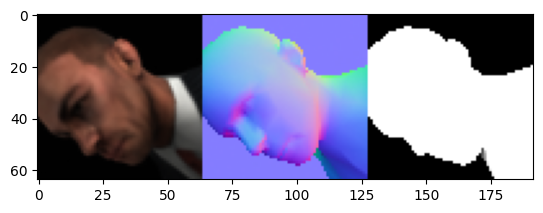

In [20]:
numberouno = 1002
plt.imshow(np.concatenate([all_photos[numberouno], all_normals[numberouno], all_masks[numberouno]], axis = 1).astype(np.float32))

In [21]:
batch_size = 64
train_size = 1
lightjumps = 57
# Test Dataset нужно грузить отдельно

dataset = tf.data.Dataset.from_tensor_slices((all_photos, all_normals))

dataset = dataset.shuffle(buffer_size=512, seed=13)

train_dataset = dataset.batch(64, drop_remainder=True)
print(all_photos.shape)

(2880, 64, 64, 3)


In [22]:
def GiveModel():
    image_input = keras.layers.Input(shape=(64, 64, 3), name='image_input')
    x = keras.layers.Conv2D(4, (3, 3), activation='relu', padding="same")(image_input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(7, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    # Полносвязный слой
    z = keras.layers.Dense(2*16*16, activation='tanh')(x)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(6*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(8*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(6*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    

    resh = keras.layers.Reshape((16, 16, 4))(do)
    anticonv1 = keras.layers.Conv2DTranspose(4, (3, 3), strides=(2,2), padding='same', activation='relu')(resh)
    output = keras.layers.Conv2DTranspose(3, (3, 3), strides=(2,2), padding='same', activation='relu')(anticonv1)
    
    # Создание модели
    model = keras.models.Model(inputs=[image_input], outputs=output)
    return model

In [24]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00016)

In [89]:
model = get_U_Net((64,64,3))
model.summary()
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00004)
model.compile(optimizer=g_optimizer_image, loss='mse')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_23 (Conv2D)             (None, 64, 64, 32)   896         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 64, 64, 32)  128         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_18 (ReLU)                (None, 64, 64, 32)   0           ['batch_normalization_18[0]

In [ ]:
'''model = GiveModel()
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()'''

In [81]:
model.fit(train_dataset, epochs=200)

Epoch 1/200
45/45 [==============================] - 1s 14ms/step - loss: 0.4012
Epoch 2/200
45/45 [==============================] - 1s 15ms/step - loss: 0.3778
Epoch 3/200
45/45 [==============================] - 1s 13ms/step - loss: 0.3671
Epoch 4/200
45/45 [==============================] - 1s 14ms/step - loss: 0.3585
Epoch 5/200
45/45 [==============================] - 1s 14ms/step - loss: 0.3512
Epoch 6/200
45/45 [==============================] - 1s 15ms/step - loss: 0.3445
Epoch 7/200
45/45 [==============================] - 1s 16ms/step - loss: 0.3379
Epoch 8/200
45/45 [==============================] - 1s 13ms/step - loss: 0.3312
Epoch 9/200
45/45 [==============================] - 1s 13ms/step - loss: 0.3240
Epoch 10/200
45/45 [==============================] - 1s 14ms/step - loss: 0.3163
Epoch 11/200
45/45 [==============================] - 1s 14ms/step - loss: 0.3081
Epoch 12/200
45/45 [==============================] - 1s 15ms/step - loss: 0.2995
Epoch 13/200
45/45 [=====

1/1 [==============================] - 0s 24ms/step


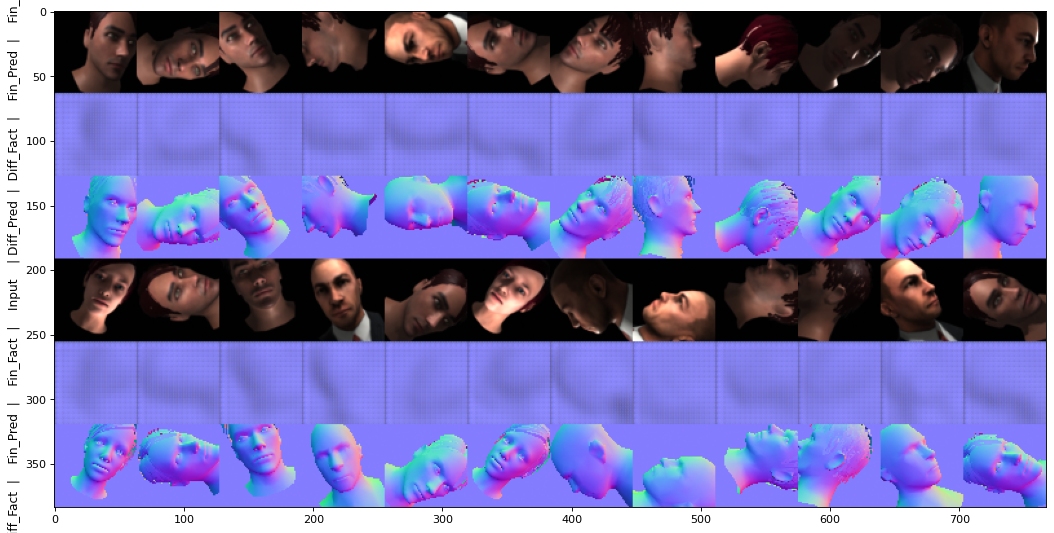

In [87]:
toinset = np.array([i * 25 for i in range(24)])
inputs = all_photos[toinset];  
predictions = model.predict(inputs)
loc_normals = all_normals[toinset]

final_image = np.concatenate([
    np.concatenate(inputs[0:12], axis=1),
    np.concatenate(predictions[0:12], axis=1),
    np.concatenate(loc_normals[0:12], axis=1),
    np.concatenate(inputs[12:24], axis=1),
    np.concatenate(predictions[12:24], axis=1),
    np.concatenate(loc_normals[12:24], axis=1),
    ], axis = 0
)

plt.figure(figsize=(16, 12), dpi=80)
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(final_image.astype("float32").clip(0,1))

In [83]:
model.evaluate(all_photos_test, all_normals_test)

4/4 [==============================] - 0s 6ms/step - loss: 0.0178


0.017750436440110207

1/1 [==============================] - 0s 20ms/step


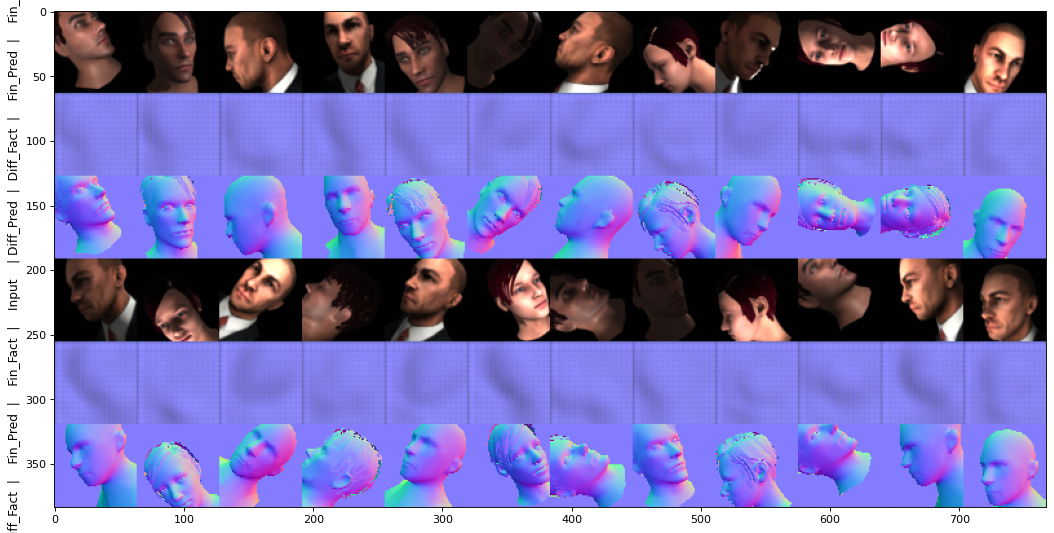

In [84]:
toinset = np.array([i for i in range(24)]); 
test_inputs = all_photos_test[toinset];  
test_normals = all_normals_test[toinset]; 

predictions_test = model.predict(test_inputs)
 

final_image = np.concatenate([
    np.concatenate(test_inputs[0:12], axis=1),
    np.concatenate(predictions_test[0:12], axis=1),
    np.concatenate(test_normals[0:12], axis=1),
    np.concatenate(test_inputs[12:24], axis=1),
    np.concatenate(predictions_test[12:24], axis=1),
    np.concatenate(test_normals[12:24], axis=1),
    ], axis = 0
)

plt.figure(figsize=(16, 12), dpi=80)
plt.ylabel("Diff_Pred   |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    | Diff_Pred  |  Diff_Fact  |    Fin_Pred  |    Fin_Fact  |    Input    |", fontsize=11)
plt.imshow(final_image.astype("float32").clip(0,1))

1/1 [==============================] - 0s 20ms/step


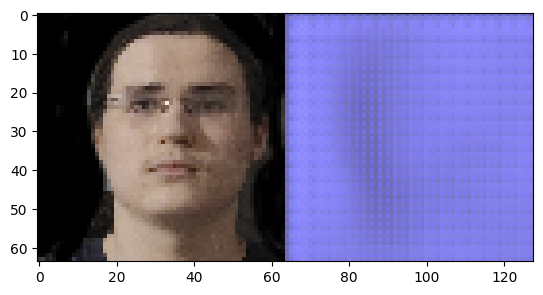

In [88]:
# Вообще работает правильно. Освещенные части оно затемнило, 
# но, из-за того что все картинки в обуч. наборе оранжевые, она затемнила синеватым цветом
dude_pic = Image.open("me.png")
dude_pic = np.array(dude_pic) / 255
dude_normal = model.predict(dude_pic.reshape((1,64,64,3)))[0]
plt.imshow(np.clip(np.concatenate([dude_pic, dude_normal], axis = 1), 0, 1))

In [86]:
#model.save("human_face_UNET_normal.keras")